In [23]:
import os
import joblib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, precision_score

In [11]:
df = pd.read_csv('../data/processed.csv')
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
# n_estimators=100: Create 100 decision trees
# class_weight='balanced': Give more weight to "Churn=1" (The minority class)
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

preds = rf.predict(X_test)

print("---- Accuracy Score ----")
print(f"{accuracy_score(y_test, preds):.4f}")

print("\n--- Classification Report ---")
print(classification_report(y_test, preds))

print('\n ---- Confusion Matrix ---- ')
cm = confusion_matrix(y_test, preds)
print(cm)

print(f"Stayers Correctly Identified: {cm[0][0]}")
print(f"Stayers Mistaken for Churners: {cm[0][1]}")
print(f"Churners Missed: {cm[1][0]}")
print(f"Churners Caught: {cm[1][1]}")

---- Accuracy Score ----
0.7942

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1036
           1       0.66      0.45      0.54       373

    accuracy                           0.79      1409
   macro avg       0.74      0.68      0.70      1409
weighted avg       0.78      0.79      0.78      1409


 ---- Confusion Matrix ---- 
[[951  85]
 [205 168]]
Stayers Correctly Identified: 951
Stayers Mistaken for Churners: 85
Churners Missed: 205
Churners Caught: 168


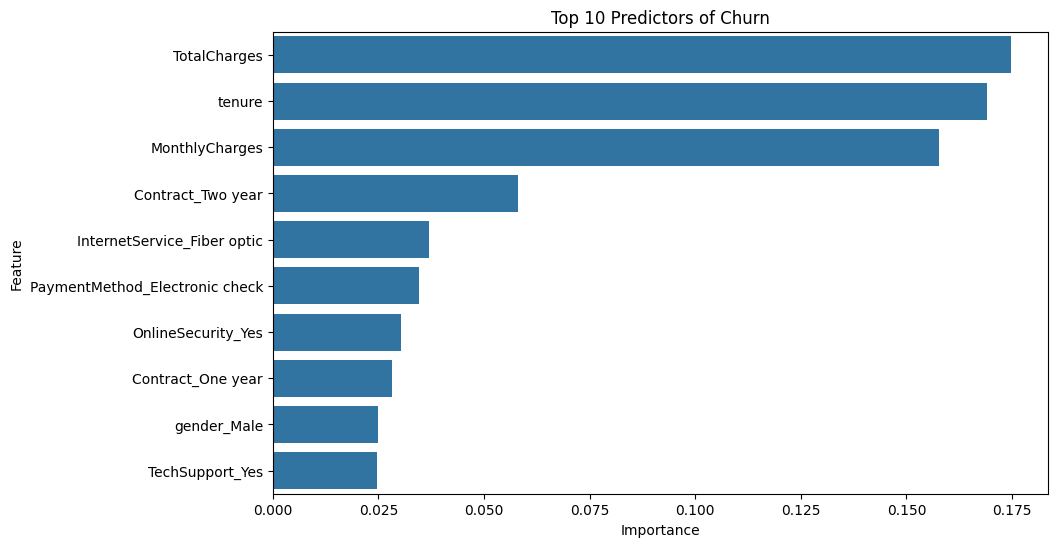

In [13]:
# Get numerical feature importances
importances = rf.feature_importances_

# Get feature names
feature_names = X.columns

# Create a DataFrame for nice printing
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance (Highest first)
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot Top 10
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10))
plt.title("Top 10 Predictors of Churn")
plt.show()


In [22]:
# 1. Get the Probabilities (Instead of just 0 or 1)
# Returns a list like [0.7, 0.3] -> We want the second number (Probability of Churn)
y_probs = rf.predict_proba(X_test)[:, 1]

# 2. Test a Lower Threshold (e.g., 0.3 instead of 0.5)
new_threshold = 0.3
y_pred_adjusted = [1 if prob >= new_threshold else 0 for prob in y_probs]

# 3. Evaluate the New Result
print(f"--- Performance at Threshold {new_threshold} ---")
print(f"New Recall (Caught Churners): {recall_score(y_test, y_pred_adjusted):.2f}")
print(f"New Precision (False Alarms): {precision_score(y_test, y_pred_adjusted):.2f}")

# Compare with the confusion matrix
cm = confusion_matrix(y_test, y_pred_adjusted)
print(f"\nChurners Caught now: {cm[1][1]} (Was 168)")
print(f"Churners Missed now: {cm[1][0]} (Was 205)")

--- Performance at Threshold 0.3 ---
New Recall (Caught Churners): 0.73
New Precision (False Alarms): 0.54

Churners Caught now: 274 (Was 168)
Churners Missed now: 99 (Was 205)


In [25]:
# Create models folder
os.makedirs('../models', exist_ok=True)

# 1. Save the Model
joblib.dump(rf, '../models/rf.joblib')

# 2. Save the Feature Names (The "Skeleton")
# We need this to ensure the app creates the exact same 31 columns
joblib.dump(X_train.columns.tolist(), '../models/churn_columns.joblib')

print("✅ Model and Feature Columns saved!")
print(f"Total Columns Saved: {len(X_train.columns)}")

✅ Model and Feature Columns saved!
Total Columns Saved: 30
